In [1]:
from non_adaptive import NonAdaptive
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import itertools
import time
from tqdm import tqdm
import sympy as sp
x = sp.var('x')
from sympy import Symbol
from sympy.solvers import solve


Parameters:
mu : 0.00015
gamma: 0.0027
beta : 0.009
phi: 0.0044


Multiple roots condition satisfied:
True

Contact rates per group:
Cs = 0.4
Ci = 0.32000000000000006
Cz = 0.68


R0 value: 1.0105263157894737
kappa: 0.8
xi: 1.7

Theoretical Possible Equilibria Roots:
[0.004914312662359203, 0.010455203872732766, 0.23809938298643937]


Point attained at the equilibrium:
0.2380988541694913



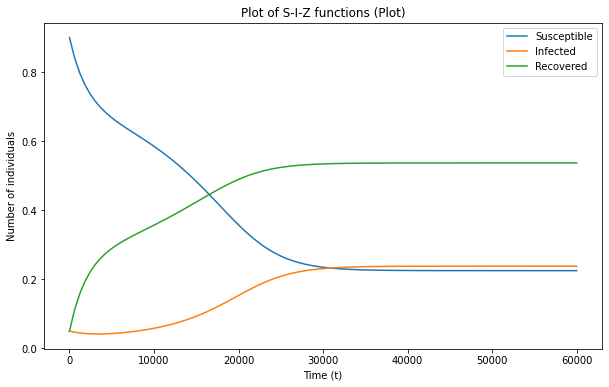

In [13]:
# Initial parameters
mu = 0.00015
gamma = 0.0027
beta = 0.009
phi = 0.0044

kappa = 0.8  #C^I/C^S
xi = 1.7 #C^Z/C^S

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

print(f"""
Parameters:
mu : {mu}
gamma: {gamma}
beta : {beta}
phi: {phi}
""")

# Number for three roots condition: (Theorem)
print(f"""
Multiple roots condition satisfied:
{Rphi - (Rmu**2 + 1)/(Rmu**2 - Rmu + 1) > 0}
""")

Cs = 0.4
Ci = Cs*kappa
Cz = Cs*xi

print(f"""Contact rates per group:
Cs = {Cs}
Ci = {Ci}
Cz = {Cz}
""")

R0 = Ci*beta/(gamma+mu)
roots = solve_polynomial(Rphi, Rmu, R0, kappa, xi)

print(f"""
R0 value: {R0}
kappa: {kappa}
xi: {xi}

Theoretical Possible Equilibria Roots:
{roots}
""")

t_max = 60000
steps = 100
x00 = [0.9, 0.05, 0.05]

non_adaptive = NonAdaptive(mu, gamma, beta, phi, Cs, Ci, Cz, t_max, steps, x00)
non_adaptive.solve_odes_system()

print(f"""
Point attained at the equilibrium:
{non_adaptive.I[len(non_adaptive.I) - 1]}
""")

non_adaptive.plot_ode_solution(t = np.linspace(0,t_max,steps), title="Plot")

In [ ]:
def get_coefficients_cubic(Rphi, Rmu, R0, kappa, xi):

    ### Returns the coefficients x3,x2,x1,x0 of the cubic polynomial in the notes.

    """
    kappa := C^i/C^s
    xi := C^z/C^s
    """

    x_3 = (Rphi**2)*(R0) + Rmu*(Rphi**2)*(kappa -1)
    
    x_2 = Rphi*(R0*(1 - Rphi) + Rmu*(R0 + Rphi))
    x_2 = x_2 + Rphi*(Rmu*(1 - Rmu)*(xi - 1) + Rmu*(1 + Rmu)*(kappa - 1)) 

    x_1 = Rmu*(R0*(1 - Rphi)  + Rphi*(1 - R0)  + Rmu*Rphi)
    x_1 = x_1+ Rmu*((1 - Rmu)*(xi - 1) + Rmu*(kappa - 1))

    x_0 = (Rmu**2)*(1 - R0)

    return [x_0,x_1,x_2,x_3]

def nmbr_rts_interval(Rphi, Rmu, val_tuple):

    kappa = val_tuple[0]
    xi = val_tuple[1]
    
    print(f"Processing tuple {(kappa,xi)}.")
    start_tuple = time.time()

    R0s = list(np.linspace(0.0001,2,1000))
    vals = []

    for R0 in tqdm(R0s):

        # Compute number of roots using Sturm's Theorem

        coefficients = get_coefficients_cubic(Rphi, Rmu, R0, kappa, xi)
        pol = sum([coefficients[i]*x**i for i in range(len(coefficients))])
        sturm_seq = sp.sturm(pol) # sturm sequence

        values_at_start = [float(sp.Poly(pol_sturm,x).eval(0)) for pol_sturm in sturm_seq]
        values_at_end = [float(sp.Poly(pol_sturm,x).eval(1)) for pol_sturm in sturm_seq]

        count_start = len(list(itertools.groupby(values_at_start, lambda values_at_start: values_at_start > 0)))
        count_end = len(list(itertools.groupby(values_at_end, lambda values_at_end: values_at_end > 0)))

        ans = count_start - count_end
        vals.append(ans)

    answer = max(vals)
    return answer

def evaluate_cubic(i, Rphi, Rmu, R0, kappa, xi):
    [x_0,x_1,x_2,x_3] = get_coefficients_cubic(Rphi, Rmu, R0, kappa, xi)
    return x_3*(i**3) + x_2*(i**2) + x_1*i + x_0

def solve_polynomial(Rphi, Rmu, R0, kappa, xi):
    
    x = Symbol('x')
    resp = solve(evaluate_cubic(x, Rphi, Rmu, R0, kappa, xi), x)
    resp = [(float(expr.as_real_imag()[0]), float(expr.as_real_imag()[1]) ) for expr in resp]
    resp = [expr[0] for expr in resp if expr[0]>0 and abs(expr[1])<1e-15]
    
    return resp